# **Implied Volatility Surface Modelling**

In [2]:
%load_ext autoreload
%autoreload 2

import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from abc import ABC, abstractmethod
from mpl_toolkits.mplot3d import Axes3D
from typing import Tuple
from scipy.interpolate import griddata, interp1d
from scipy.optimize import differential_evolution, minimize

import utility.plot_helpers as ph

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options["T"] = options["dte"] / 252 # Time to expity in years
options["k"] = np.log(
    options["strike"] / options["underlying_last"] # log moneyness
 )
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask,T,k
date,,,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,8.17536,3041.37,0.03,1.0,7.0,2846.8,2848.3,0.0,0.05,0.000000,-1.348953
2023-01-04,1200.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,7.06724,0.00,0.00,1.0,0.0,2646.8,2648.3,0.0,0.05,0.000000,-1.166632
2023-01-04,1400.0,3853.39,0.0,2023-01-04,1.00000,-0.00025,NaN,6.13893,0.00,0.00,0.0,0.0,2427.6,2471.0,0.0,0.05,0.000000,-1.012481
2023-01-04,1600.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,5.33125,2417.29,0.00,1.0,0.0,2246.8,2248.3,0.0,0.05,0.000000,-0.878950
2023-01-04,1800.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,4.61644,0.00,0.00,0.0,0.0,2046.8,2048.3,0.0,0.05,0.000000,-0.761167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.00,0.00,0.0,0.0,286.8,366.8,1550.9,1630.90,8.666667,0.411280
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.00,0.00,0.0,0.0,245.4,325.4,1669.0,1749.00,8.666667,0.438679
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.00,0.00,0.0,0.0,208.7,288.7,1791.8,1871.80,8.666667,0.465347


In [4]:
# Calibration day
date = '2023-12-20'
options_red = options[options.index == date]

In [66]:
class IVSurfaceModel(ABC):
    """Abstract base for any IV‐surface model."""
    def __init__(self):
        # once you fit, we’ll remember the spot price
        self._spot: float = None
        
    @staticmethod
    def prepare_iv_surface(options: pd.DataFrame):
        df = options.copy()

        # choose OTM vol
        df['iv_smile'] = np.where(
            df['strike'] < df['underlying_last'], 
            df['p_iv'],
            np.where(
                df['strike'] > df['underlying_last'], 
                df['c_iv'], 
                0.5*(df['c_iv'] + df['p_iv'])
            )
        )
        df['k'] = np.log(df['strike'] / df['underlying_last'])
        df['w'] = df['iv_smile']**2 * df['T'] # total variance

        return df
    
    @staticmethod
    def _moneyness_band(T):
        """Return (m_lo, m_hi) given T in years."""
        days = T * 252
        if days < 7:
            return 0.90, 1.05
        elif days < 30:
            return 0.85, 1.15
        elif days < 180:
            return 0.80, 1.20
        else:
            return 0.70, 1.30

    @abstractmethod
    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate to raw market quotes (DataFrame of k, T, σ_mkt)."""
        pass

    @abstractmethod
    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Return total variance w(k,T)."""
        pass
    
    def implied_vol(self, K: np.ndarray, T: np.ndarray) -> np.ndarray:
        K_arr = np.atleast_1d(K).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        if not hasattr(self, "_spot"):
            raise RuntimeError("You must .fit(...) first to set self._spot")

        k_arr = np.log(K_arr / self._spot)
        
        w = self._implied_total_variance(k_arr, T_arr)

        if w.ndim == 2 and T_arr.ndim == 1:
            T_arr = T_arr[:, None]

        iv = np.sqrt(w / T_arr)
        return iv.item() if iv.size == 1 else iv
    

    def greeks(self, k, T, S, dS, dSigma, dt):
        """Compute Δ, Γ, Θ, ν via analytic repricer if available."""
        raise NotImplementedError  # override if your model supports Greeks

    def check_arbitrage(self):
        """Run convexity & monotonicity diagnostics."""
        # e.g. finite‐diff ∂^2w/∂k^2 ≥ 0, ∂w/∂T ≥ 0
        pass
    
    def plot_smiles(
            self,
            target_days=[1,5,10,15,20,25,30,40,50,60,126,252],
            #moneyness_band: Tuple[float, float] = [0.8, 1.2],
            total_var=False,
    ):
        """
        3×4 grid of IV(k) using the maturities closest to `target_days`.
        """
        df = self._last_market.copy()
        df["days"] = (df["T"] * 252).round().astype(int)

        """
        strikes_obs = df["strike"]
        K_min, K_max = strikes_obs.min(), strikes_obs.max()
        if moneyness_band is not None:
            m_lo, m_hi = moneyness_band
            spot = df["underlying_last"].iloc[0]
            K_min = max(K_min, spot * m_lo)
            K_max = min(K_max, spot * m_hi)

        df = df[(df["strike"] >= K_min) & (df["strike"] <= K_max)]
        """
        def closest_distinct(avail_days, targets):
            avail = np.asarray(sorted(avail_days))
            chosen = []
            for t in targets:
                if avail.size == 0:
                    chosen.append(None)            # placeholder -> blank subplot
                    continue
                idx = np.abs(avail - t).argmin()
                chosen.append(int(avail[idx]))
                avail = np.delete(avail, idx)      # no duplicates
            return chosen

        # choose the nearest available maturity for each target
        chosen_days = closest_distinct(df["days"].unique(), target_days)

        # build 3×4 grid
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        axes = axes.flatten()

        for ax, D in zip(axes, chosen_days):
            if D is None:            # no maturity left—blank this cell
                ax.axis("off")
                continue

            T_i = D / 252.0
            slice_df  = df[np.isclose(df["T"], T_i)]
            
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            slice_df = slice_df[
                (slice_df["k"] >= k_lo) & 
                (slice_df["k"] <= k_hi)
            ].copy()
            
            k = slice_df["k"].values

            if total_var:
                model = slice_df["w"].values
                market = self._implied_total_variance(k, T_i).ravel()
            else:
                model = slice_df["iv_smile"].values
                market = self.implied_vol(slice_df["strike"], T_i).ravel()
            label = "TIVar" if total_var else "IV"

            ax.scatter(k, model, s=18, alpha=0.8, color="blue", label=f"Market {label}")
            ax.plot(k, market, color="red", label=f"Model {label}")
            ax.axvline(0, lw=.6, c="black", linestyle="--")

            ax.set_title(f"DTE = {int(D)}", fontsize=12)
            ax.set_xlabel("Log-Forward Moneyness (k)")
            title = "Total Implied Variance" if total_var else "Implied Volatility (IV)"
            ax.set_ylabel(f"{title}")
            ax.legend(loc="upper right")

        title = "SVI vs Market "
        title += "Total Implied Variances" if total_var else "Implied Volatilities"
        fig.suptitle(title, fontsize=18, y=1.02)
        fig.tight_layout()
        plt.show()

    def plot_surface(
        self,
        moneyness_band=(0.8, 1.2),
        dte_band=(1, 60),
        n_strikes=50,
        n_dtes=50,
        method_name=None,
        ax=None,
    ):
        """Plot the full IV surface over strike and maturity."""
        df = self._last_market.copy()
        spot = df["underlying_last"].iloc[0]

        # filter maturities
        df['DTE'] = (df['T'] * 252).round().astype(int)
        valid = np.unique(df['DTE'])
        d_min, d_max = dte_band
        dtes = valid[(valid >= d_min) & (valid <= d_max)]
        if len(dtes)==0:
            raise ValueError("No expiries in dte_band")
        
        # build T grid in years
        T_grid = np.linspace(d_min/252, d_max/252, n_dtes)

        # determine strike band
        strikes_obs = df[df['DTE'].isin(dtes)]['strike']
        K_min = max(strikes_obs.min(), spot*moneyness_band[0])
        K_max = min(strikes_obs.max(), spot*moneyness_band[1])
        K_grid = np.linspace(K_min, K_max, n_strikes)

        # mesh and evaluate
        IV_mesh = self.implied_vol(K_grid, T_grid)
        K_mesh, T_mesh = np.meshgrid(K_grid, T_grid)

        if ax is None:
            fig = plt.figure(figsize=(12, 8))
            ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(
            K_mesh, T_mesh*252, IV_mesh,
            cmap='viridis', alpha=0.8, antialiased=True

        )

        for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
            ginfo = axis._axinfo["grid"]
            ginfo['color']     = (0.1, 0.1, 0.1, 0.2)
            ginfo['linewidth'] = 0.5
        
        ax.set_facecolor('white')
        ax.zaxis.labelpad = 10 
        ax.tick_params(axis='z', pad=6)
        ax.set_xlabel('Strike', fontsize=12)
        ax.set_ylabel('DTE (days)', fontsize=12)
        ax.set_zlabel('Implied Vol', fontsize=12)
        title = 'Implied Volatility Surface'
        title += f": {method_name}" if method_name else ""
        ax.set_title(title, fontsize=16, y=1.03)
        
        cbar = plt.colorbar(surf, ax=ax, pad=0.1, shrink=0.5, aspect=10)
        cbar.set_label('IV', rotation=0, labelpad=15)

        return ax

## **Non-parametric: Spline interpolation**


In [67]:
class InterpSurface(IVSurfaceModel):
    """
    Non-parametric interpolator for total implied variance w(k, T).
    - If only one unique T is provided, falls back to 1D interpolation in k.
    - Otherwise uses 2D griddata interpolation.
    """
    def __init__(self, method: str = 'cubic'):
        self.method = method
        self._1d_spline = None
        self._2d_data = None

    def fit(self, market_data: pd.DataFrame) -> None:
        """Fit the interpolator."""
        self._spot = market_data["underlying_last"].iloc[0]

        df = self.prepare_iv_surface(market_data)
        ks = df['k'].to_numpy()
        Ts = df['T'].to_numpy()
        ws = df['w'].to_numpy() # Total variance
        self._last_market = df.copy()

        unique_T = np.unique(Ts)
        if len(unique_T) == 1:
            # Single-maturity case: build a 1D spline in k
            order = np.argsort(ks)
            self._1d_spline = interp1d(
                ks[order], ws[order],
                kind=self.method,
                fill_value="extrapolate",
            )
        else:
            # Full-surface case: store the raw arrays for 2D interpolation
            self._2d_data = (ks, Ts, ws)

    def _implied_total_variance(self, k: np.ndarray, T: np.ndarray) -> np.ndarray:
        """Query the interpolated total variance w(k, T)."""
        if self._1d_spline is not None:
            # Only one maturity in fit → ignore T
            return self._1d_spline(k)
        
        # 2D interpolation via griddata
        ks, Ts, ws = self._2d_data
        pts = np.column_stack((ks, Ts))

        # 2) build a mesh of *query* k‐and‐T pairs
        Kq, Tq = np.meshgrid(k, T, indexing="xy")        # (len(T), len(k))
        qry = np.column_stack((Kq.ravel(), Tq.ravel())) # (len(T)*len(k), 2)

        # 3) interpolate and reshape back into (len(T), len(k))
        Wq = griddata(pts, ws, qry, method=self.method)
        return Wq.reshape(len(T), len(k))

In [68]:
interp_iv = InterpSurface(method='linear')
interp_iv.fit(options_red)

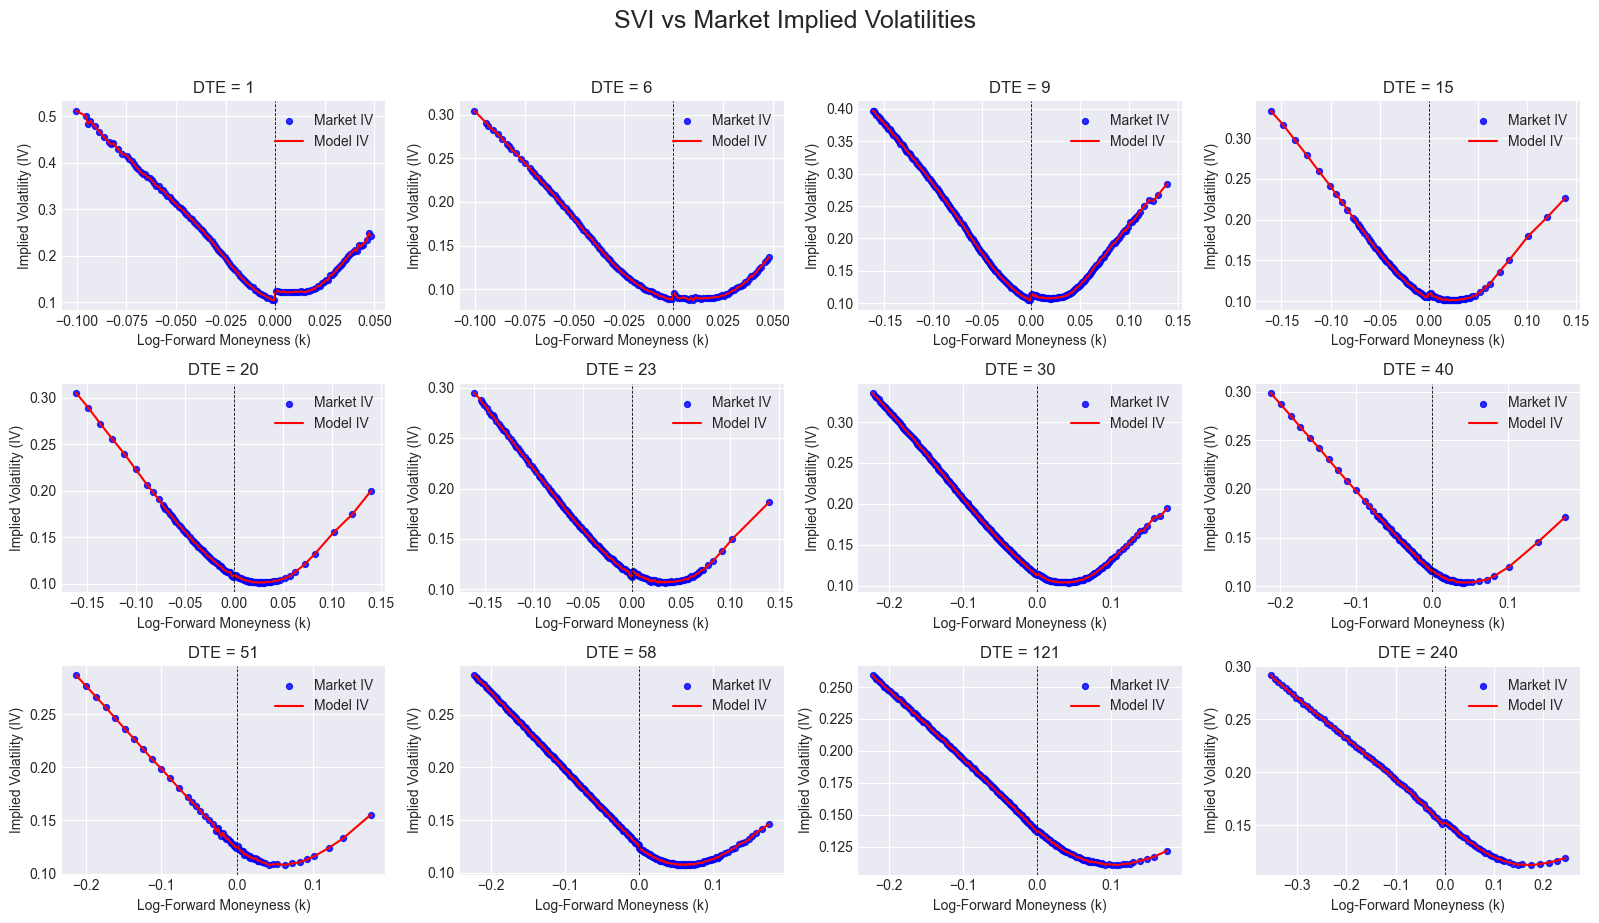

In [69]:
interp_iv.plot_smiles()

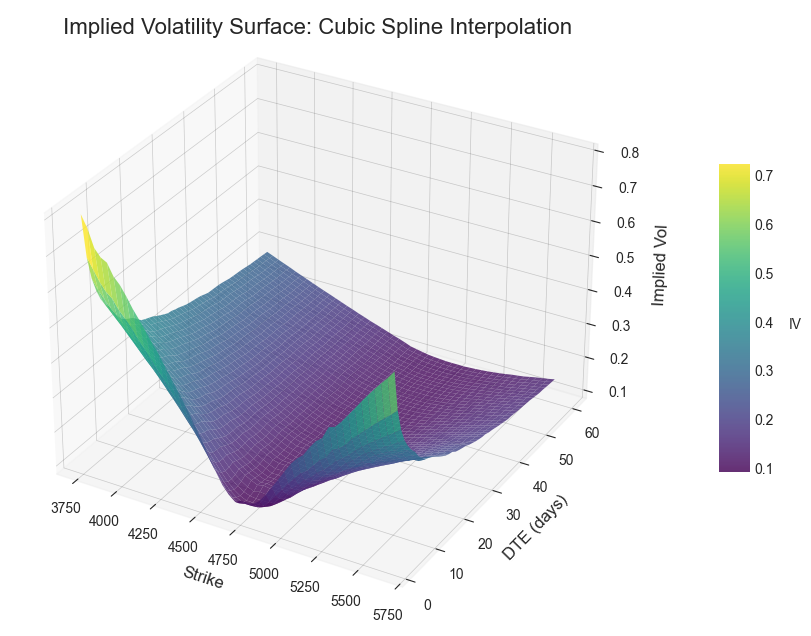

In [71]:
interp_iv.plot_surface(
    method_name="Cubic Spline Interpolation",
    dte_band=(2,60),
)
plt.show()

## **Parametric: Stochastic Volatility Inspired (SVI) model**

In [79]:
class SVI(IVSurfaceModel):
    """
    Per‐slice “raw” SVI with smooth interpolation of parameters across T.
    """
    param_names = ("a", "b", "rho", "m", "sigma")
    def __init__(self,
                 init_guess: dict = None,
                 bounds: dict = None,
                 use_dynamic_init_guess=True,
                 use_dynamic_bounds: bool = True,
                 atm_weighting: bool = True,
                 min_pts: int = 6,
                 moneyness_band: Tuple = (0.8, 1.2),
                 maturity_band: Tuple = (1/252, 2),
                 interp_kind: str = 'linear'):
        super().__init__()

        # default SVI parameter bounds for raw‐SVI slice calibration
        default_bounds = {
            # total variance offset must be non-negative, but not unbounded
            'a':     (1e-6, 1.0),
            # variance slope b must be positive
            'b':     (1e-2,    1.0),
            # correlation ρ strictly between –1 and +1
            'rho':   (-0.999,  0.999),
            # m (log-moneyness shift) usually within ±1 log‐unit
            'm':     (-1.0,    1.0),
            # σ controls smile curvature: small but strictly positive
            'sigma': (1e-3,    1.0),
        }
        self.init_guess_user = init_guess or {}       # user overrides
        self.bounds       = bounds or default_bounds
        self.use_dyn = use_dynamic_init_guess
        self.use_dynamic_bounds = use_dynamic_bounds
        self.moneyness_band = moneyness_band
        self.maturity_band = maturity_band
        self.interp_kind  = interp_kind
        self.atm_weighting = atm_weighting # e.g. [0, 1, ..., ,9, 10, 9, ..., 1, 0]
        self.min_pts  = min_pts  # min nb of calibration points for the smile

        self.params_by_T  = {}     # raw SVI fits: T -> (a,b,rho,m,sigma)
        self._param_interp = {}    # after fit: name -> interp1d over T

    @staticmethod
    def _svi_raw(k, a, b, rho, m, sigma):
        """Raw SVI total‐variance formula:"""
        return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))
    
    def _default_vector(self, k, w):
        """Return the 5-vector of slice-specific defaults."""
        if self.use_dyn:
            a0 = max(0.0, w.min())
            b0 = min((w.max()-w.min())/ (np.ptp(k)+1e-6), 0.10)
            m0 = k[np.argmin(w)]
            sigma0 = min(np.std(k)*0.1 + 1e-3, 0.10)
            dw_dk = np.gradient(w, k)[np.argmin(np.abs(k))]
            rho0  = np.clip(dw_dk/b0, -0.8, 0.4) if b0>0 else 0.0
        else:                              # static fall-back numbers
            a0, b0, rho0, m0, sigma0 = 0.01, 0.10, 0.0, 0.0, 0.05
        return dict(a=a0, b=b0, rho=rho0, m=m0, sigma=sigma0)

    def _initial_guesses(self, k, w):
        """Yield one np.array per Cartesian combination."""
        base = self._default_vector(k, w)

        # merge user overrides (scalar or iterable)
        param_lists = {}
        for name in self.param_names:
            if name in self.init_guess_user:
                user_val = self.init_guess_user[name]
                param_lists[name] = (user_val if isinstance(user_val,
                                         (list,tuple,np.ndarray))
                                     else [user_val])
            else:
                param_lists[name] = [base[name]]        # single default

        # Cartesian product over only those lists with >1 element
        for combo in itertools.product(*(param_lists[p] for p in self.param_names)):
            yield np.array(combo, float)

    def _calibrate_raw_svi(self, k, w, T):
        lb = np.array([self.bounds[n][0] for n in self.param_names])
        ub = np.array([self.bounds[n][1] for n in self.param_names])

        if self.use_dynamic_bounds:
            ub[0]  = 0.5*np.max(w)   # a <= 1/2*max(w)
            lb[3] = 2*np.min(k) # 2*np.min(k) <= m <= 2*np.max(k)
            ub[3] = 2*np.max(k)
            lb[1] = 1e-2

            if T < 0.05: # ≈ 13 DTE
                lb[3], ub[3] = -0.3, 0.3  # tighter m-bounds 

        def sse(params):
            model = self._svi_raw(k, *params)
            resid = model - w

            if self.atm_weighting and T <= 0.05: # ≈ 13 DTE
                weights = 1.0 / (np.abs(k) + 0.01)**2 # steeper ATM weight
            elif self.atm_weighting:
                weights = 1.0 / (np.abs(k) + 0.05) 
            else:
                weights = 1

            return np.sum(weights * (resid)**2)

        # ------------- main: Quasi-newton optimization -------------
        best = None
        for x0 in self._initial_guesses(k, w):
            x0 = np.clip(x0, lb, ub)
            sol = minimize(sse, x0, bounds=list(zip(lb,ub)),
                           method="L-BFGS-B",
                           options={"maxiter": 1000})
            if sol.success and (best is None or sol.fun < best.fun):
                best = sol

        if best is None:
            raise RuntimeError("SVI slice failed for all initial guesses")
        
        # ------------- quality gauges -----------------------------
        # errors in vol
        p_best = best.x
        w_model = self._svi_raw(k, *p_best)
        sig_market = np.sqrt(w / T)      # market vols
        sig_model = np.sqrt(w_model / T)
        err = sig_market - sig_model
        max_abs = np.max(np.abs(err))
        rmse = np.sqrt(np.mean(err**2))

        # decide if fit is good enough
        if rmse < 0.02 and max_abs < 0.05:
            return tuple(p_best)           

        # ------------- fallback: Differential Evolution -----------
        de = differential_evolution(
                sse, bounds=list(zip(lb,ub)),
                strategy='best1bin', popsize=30, maxiter=300,
                tol=1e-7, polish=False  # we'll polish ourselves
            )
        pol = minimize(sse, de.x, bounds=list(zip(lb,ub)),
                    method='L-BFGS-B', options={'maxiter':500})
        if pol.success and pol.fun < best.fun:
            best = pol
            
        return tuple(best.x)

    def fit(self, market_data: pd.DataFrame) -> None:
        """Calibrate an independent raw‐SVI slice at each maturity."""
        self._spot = market_data["underlying_last"].iloc[0]

        # prepare total‐variance (w) and log‐moneyness (k)
        df = self.prepare_iv_surface(market_data)

        # Moneyness and maturity bands
        m_lo, m_hi = self.moneyness_band
        k_lo, k_hi = np.log(m_lo), np.log(m_hi)
        min_T, max_T = self.maturity_band

        df = df[df["T"].between(min_T, max_T)].copy()
        self._last_market = df

        # fit one slice per unique T
        T_vals = []
        param_list = []

        for T_i, slice_df in df.groupby("T"):
            m_lo, m_hi = self._moneyness_band(T_i)
            k_lo, k_hi = np.log(m_lo), np.log(m_hi)
            slice_df = slice_df[
                (slice_df["k"] >= k_lo) & 
                (slice_df["k"] <= k_hi)
            ].copy()
            
            # skip very sparse slices
            if len(slice_df) < self.min_pts:
                continue

            k_i = slice_df["k"].to_numpy()
            w_i = slice_df["w"].to_numpy()

            params = self._calibrate_raw_svi(k_i, w_i, T_i)
            self.params_by_T[T_i] = params
            T_vals.append(T_i)
            param_list.append(params)

        if not T_vals:
            raise RuntimeError("No maturities had enough strikes inside k_band")

        # sort maturities and unpack params
        T_grid = np.array(T_vals)
        A = np.array([p[0] for p in param_list])
        B = np.array([p[1] for p in param_list])
        Rho = np.array([p[2] for p in param_list])
        M = np.array([p[3] for p in param_list])
        Sig = np.array([p[4] for p in param_list])

        # build 1D‐interpolators (extrapolate outside known T range)
        self._param_interp = {
            'a':     interp1d(T_grid, A, kind=self.interp_kind,
                              fill_value="extrapolate"),
            'b':     interp1d(T_grid, B, kind=self.interp_kind,
                              fill_value="extrapolate"),
            'rho':   interp1d(T_grid, Rho, kind=self.interp_kind,
                              fill_value="extrapolate"),
            'm':     interp1d(T_grid, M, kind=self.interp_kind,
                              fill_value="extrapolate"),
            'sigma': interp1d(T_grid, Sig, kind=self.interp_kind,
                              fill_value="extrapolate"),
        }

    def _implied_total_variance(self,
                          k: np.ndarray,
                          T: np.ndarray) -> np.ndarray:
        # ensure 1D arrays
        k_arr = np.atleast_1d(k).astype(float)
        T_arr = np.atleast_1d(T).astype(float)

        # query each parameter at all T
        a_vals     = self._param_interp['a'](T_arr)     # (nT,)
        b_vals     = self._param_interp['b'](T_arr)
        rho_vals   = self._param_interp['rho'](T_arr)
        m_vals     = self._param_interp['m'](T_arr)
        sigma_vals = self._param_interp['sigma'](T_arr)

        # build mesh so we can broadcast:
        Kq, Tq = np.meshgrid(k_arr, T_arr, indexing='xy')
        A     = a_vals[:, None]
        B     = b_vals[:, None]
        Rho   = rho_vals[:, None]
        M     = m_vals[:, None]
        Sig   = sigma_vals[:, None]

        return self._svi_raw(Kq, A, B, Rho, M, Sig)  

    def plot_params(self, ax=None):
        # Assemble parameters into DataFrame
        params = pd.DataFrame.from_dict(
            self.params_by_T,
            orient='index',
            columns=self.param_names
        )
        params.index.name = 'T'
        params = params.sort_index().reset_index()

        # Create axes if not provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(15, 7))

        # Plot each parameter
        for param in self.param_names:
            ax.plot(
                params['T'], params[param],
                marker='o', linestyle='-', label=param, alpha=0.8
            )

        ax.set_title('SVI Parameters vs. Maturity', fontsize=14)
        ax.set_xlabel('T (years)', fontsize=12)
        ax.set_ylabel('Parameter value', fontsize=12)
        ax.legend()
        ax.grid(True)
        plt.tight_layout()

        return ax

In [76]:
init_guess = {"rho": [ -0.7, -0.5, -0.3, -0.1, 0.0]}
svi = SVI(init_guess=init_guess, interp_kind="cubic", atm_weighting=True, moneyness_band=(0.8, 1.05))
svi.fit(options_red)

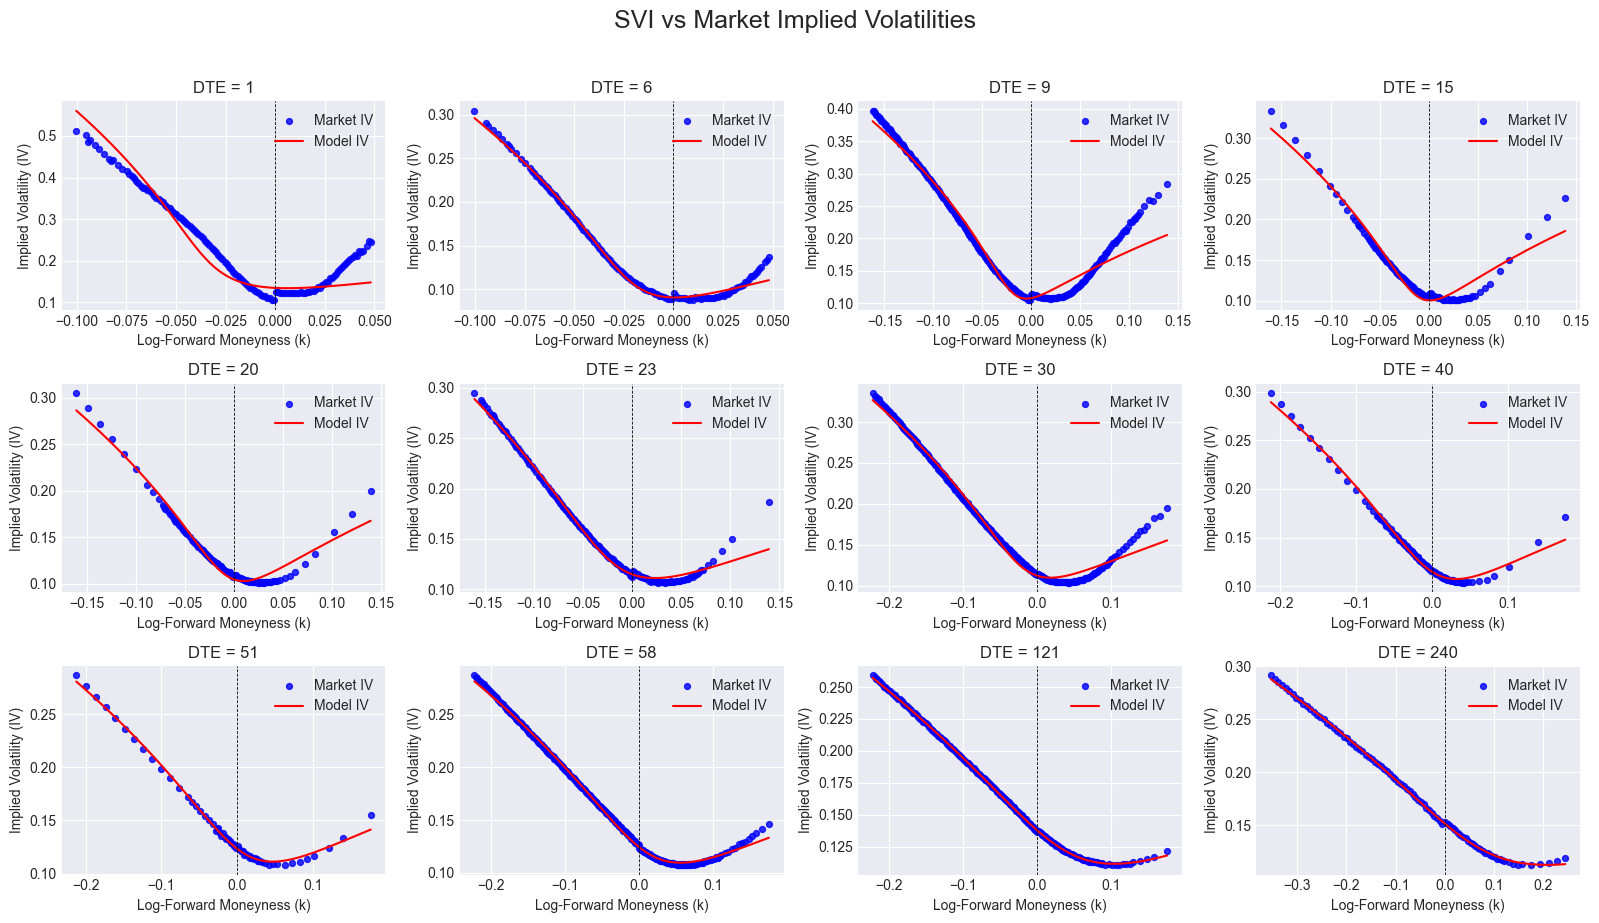

In [80]:
svi.plot_smiles()

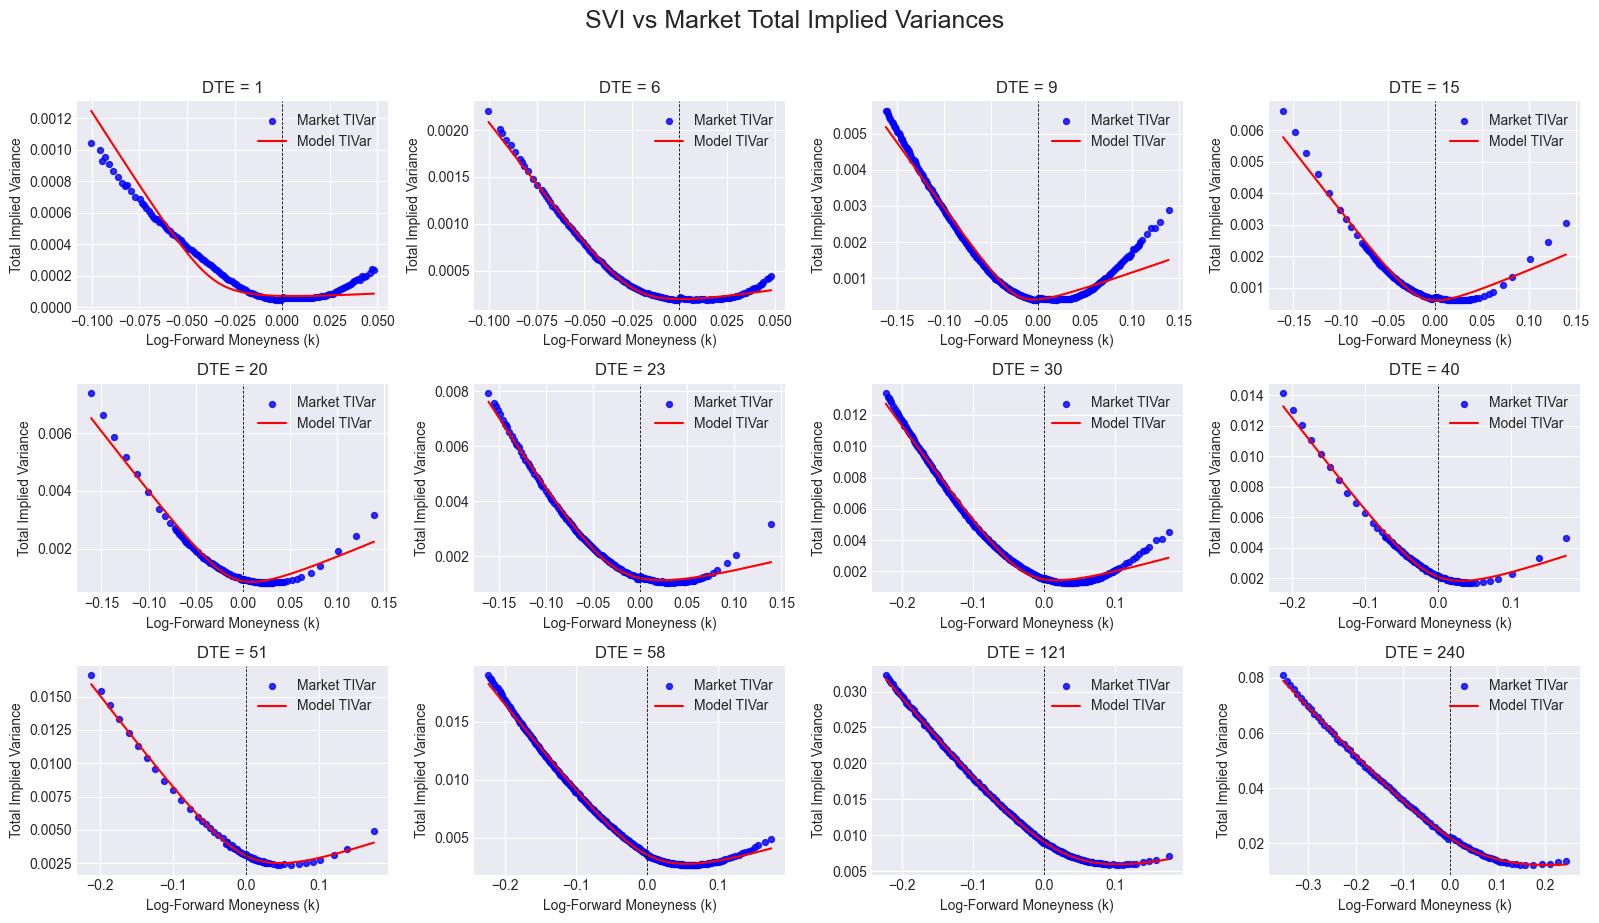

In [84]:
svi.plot_smiles(total_var=True)

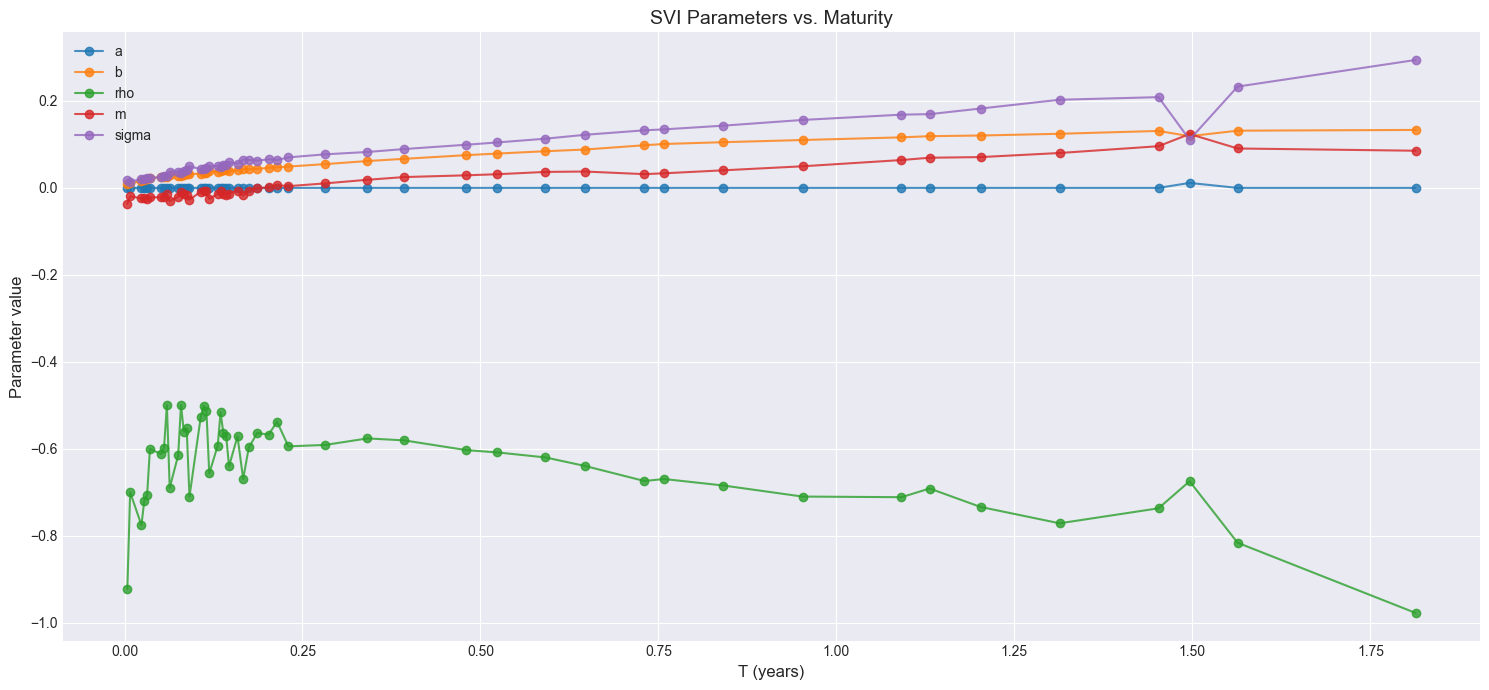

In [81]:
svi.plot_params()
plt.show()

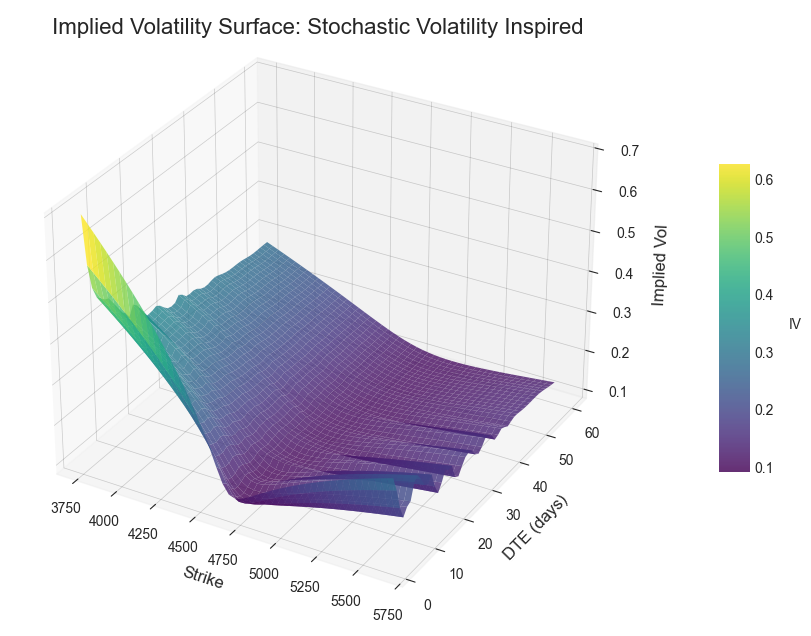

In [83]:
ax = svi.plot_surface(
    method_name="Stochastic Volatility Inspired",
    dte_band=(2 ,60)
)
plt.show()